# Pointer Generator Model

In [1]:
import torch
from PICOHelper import get_pico_datasets
from NewsroomHelper import get_newsroom_datasets
from SummarizationModelStructures import PointerGeneratorModel, loss_function, error_function
from utils import get_index_words
from pytorch_helper import VariableBatchDataLoader, ModelManipulator, plot_learning_curves

## Parameters

In [2]:
# training parameters
BATCH_SIZE = 64
NUM_EPOCHS = 1
LEARNING_RATE = 1e-2
# INITIAL_ACCUMULATOR_VALUE = 0.1
GAMMA = 1
USE_CUDA = torch.cuda.is_available()
print(USE_CUDA)
BEAM_SIZE = 4

True


## Get Data

In [3]:
# pico_dataset_train, pico_dataset_dev, pico_dataset_test = get_pico_datasets()
newsroom_dataset_train, newsroom_dataset_dev, newsroom_dataset_test = get_newsroom_datasets(with_oov=True)
word_vectors = newsroom_dataset_train.word_vectors
start_index = newsroom_dataset_train.word_indices['<start>']
end_index = newsroom_dataset_train.word_indices['<end>']

11029 3676 3678
retrieving word2vec model from file


## Create Model

In [4]:
pointer_generator_model = PointerGeneratorModel(word_vectors, start_index, end_index, num_hidden1=None, num_hidden2=None, with_coverage=False, gamma=GAMMA)

## Train and Save Model

In [5]:
dataloader = VariableBatchDataLoader(newsroom_dataset_train, batch_size=BATCH_SIZE, shuffle=True)
optimizer = torch.optim.Adam(pointer_generator_model.parameters(),
                             lr=LEARNING_RATE)
# optimizer = torch.optim.Adagrad((pointer_generator_model.cuda() if USE_CUDA else pointer_generator_model).parameters(),
#                                 lr=LEARNING_RATE, initial_accumulator_value=INITIAL_ACCUMULATOR_VALUE)
model_manip = ModelManipulator(pointer_generator_model, optimizer, loss_function, error_function, use_cuda=USE_CUDA)
train_stats, val_stats = model_manip.train(dataloader, NUM_EPOCHS, dataset_val=newsroom_dataset_dev, stats_every=10, verbose_every=10)

epoch: 0, batch: 0, train_loss: 416.196075, train_error: None
epoch: 0, batch: 10, train_loss: 376.156525, train_error: None
epoch: 0, batch: 20, train_loss: 384.555725, train_error: None
epoch: 0, batch: 30, train_loss: 357.870300, train_error: None
epoch: 0, batch: 40, train_loss: 354.882507, train_error: None
epoch: 0, batch: 50, train_loss: 341.636414, train_error: None
epoch: 0, batch: 60, train_loss: 331.915863, train_error: None
epoch: 0, batch: 70, train_loss: 337.367981, train_error: None
epoch: 0, batch: 80, train_loss: 317.487793, train_error: None
epoch: 0, batch: 90, train_loss: 322.681000, train_error: None
epoch: 0, batch: 100, train_loss: 332.824829, train_error: None
epoch: 0, batch: 110, train_loss: 318.467926, train_error: None
epoch: 0, batch: 120, train_loss: 318.913147, train_error: None
epoch: 0, batch: 130, train_loss: 323.279144, train_error: None
epoch: 0, batch: 140, train_loss: 327.112671, train_error: None
epoch: 0, batch: 150, train_loss: 327.551666, train

In [6]:
torch.save(pointer_generator_model, 'models/pointer_generator_temp.model')

In [7]:
pointer_generator_model = torch.load('models/pointer_generator_temp.model')

## Plot

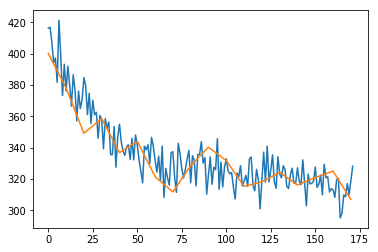

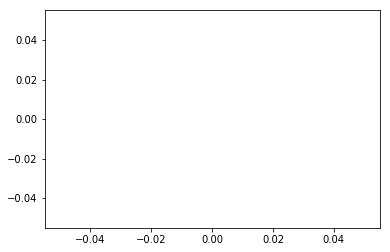

In [8]:
plot_learning_curves(training_values=train_stats, validation_values=val_stats, figure_name='graphs/pointer_generator_training_temp')

In [9]:
batch = newsroom_dataset_dev[0:2]
results, oov_indices = pointer_generator_model(batch['text'].cuda(), batch['text_length'].cuda(), batch['text_oov_indices'], beam_size=BEAM_SIZE)
# generated_output = generator_model(batch['text'], batch['text_length'])

/home/jered/Documents/Projects/Summarization/SummarizationModelStructures.py:37: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().
  output, (h, c) = self.lstm(x)


In [10]:
loss, summary_info = results[0]
for i,indices in enumerate(summary_info[0]):
    oov_words = {v:k for k,v in oov_indices[i].items()}
    text, l = batch['text'][i], batch['text_length'][i]
    print("text", get_index_words(text[:l].numpy(), newsroom_dataset_train.words, oov_words=oov_words))
    text, l = batch['summary'][i], batch['summary_length'][i]
    print("summary", get_index_words(text[:l].numpy(), newsroom_dataset_train.words, oov_words=oov_words))
    print("generated summary", get_index_words(indices[:summary_info[1][i]], newsroom_dataset_train.words, oov_words=oov_words))
    print(loss[i])

text ['<start>', 'you', 'can', 'say', 'this', 'for', 'the', 'new', 'miami', 'dolphins', 'uniforms', ':', 'it', '’s', 'not', 'the', 'worst', 'redesign', 'by', 'a', 'florida', '-', 'based', 'nfl', 'team', 'to', 'be', 'revealed', 'on', 'tuesday', '.', 'hours', 'after', 'the', 'jacksonville', 'jaguars', 'unveiled', 'their', 'new', 'xfl', '-', 'like', 'uniforms', ',', 'paul', 'lukas', 'of', 'uni', 'watch', 'tweeted', 'a', 'picture', 'of', 'the', 'leaked', 'dolphins', 'kits', 'for', 'the', 'upcoming', 'season', '.', 'confirmed', 'leak', 'of', 'new', 'miami', 'dolphins', 'uniforms', ':', 'twitter.com/uniwatch/statu', '…', '—', 'paul', 'lukas', '(', '@uniwatch', ')', 'april', 'qqq', ',', 'qqq', 'qqq', '.', 'the', 'uniforms', 'do', 'n’t', 'look', 'all', 'that', 'different', 'from', 'the', 'old', 'ones', '.', 'they', '’re', 'sleeker', 'and', 'more', 'modern', ',', 'but', 'without', 'a', 'qqq', 'press', 'release', 'from', 'nike', 'talking', 'about', 'the', 'subtle', 'shift', 'in', 'colors', 'and'